# Three-hidden-layer NN

In [25]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns


In [26]:
np.random.seed(42)

# Activation functions

def relu(Z):
    return np.maximum(0, Z)

def drelu(Z):
    # derivative of ReLU: 1 if Z>0
    return (Z > 0).astype(np.float32)

def softmax(Z):
    # Numerically stable softmax per row
    Zs = Z - np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Zs)
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def cross_entropy_loss(probs, y_true):
    n = probs.shape[0]
    clipped = np.clip(probs, 1e-12, 1.0)
    log_likelihood = -np.log(clipped[np.arange(n), y_true])
    return np.mean(log_likelihood)


Synthetic dataset (5 classes)


In [27]:
n_samples = 6000
n_features = 20
n_classes = 5

X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=15,
                           n_redundant=2,
                           n_repeated=0,
                           n_classes=n_classes,
                           n_clusters_per_class=1,
                           class_sep=2.0,
                           flip_y=0.01,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes: (4800, 20) (1200, 20) (4800,) (1200,)


Neural network class


In [28]:
class ThreeHiddenNN:
    """
    Fully-connected neural network with 3 hidden layers (ReLU) + softmax output.
    Vectorized using NumPy.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, lr=0.01, reg=1e-4):
        assert len(hidden_dims) == 3, "hidden_dims must have 3 elements"
        self.lr = lr
        self.reg = reg
        dims = [input_dim] + list(hidden_dims) + [output_dim]
        self.params = {}
        # He initialization for ReLU layers
        for i in range(len(dims)-1):
            fan_in = dims[i]
            std = np.sqrt(2.0 / fan_in)  # He init
            self.params[f'W{i+1}'] = np.random.randn(dims[i], dims[i+1]) * std
            self.params[f'b{i+1}'] = np.zeros((1, dims[i+1]))

    def forward(self, X):
        """
        Forward pass. Returns probabilities and cache for backprop.
        """
        cache = {}
        A = X
        cache['A0'] = A

        # Layer 1
        Z1 = A.dot(self.params['W1']) + self.params['b1']
        A1 = relu(Z1)
        cache['Z1'], cache['A1'] = Z1, A1

        # Layer 2
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = relu(Z2)
        cache['Z2'], cache['A2'] = Z2, A2

        # Layer 3
        Z3 = A2.dot(self.params['W3']) + self.params['b3']
        A3 = relu(Z3)
        cache['Z3'], cache['A3'] = Z3, A3

        # Output logits
        Z4 = A3.dot(self.params['W4']) + self.params['b4']
        probs = softmax(Z4)
        cache['Z4'], cache['probs'] = Z4, probs

        return probs, cache

    def compute_loss_and_gradients(self, X, y):
        """
        Compute cross-entropy loss (with L2 reg) and gradients for a batch.
        """
        n = X.shape[0]
        probs, cache = self.forward(X)
        loss = cross_entropy_loss(probs, y)

        # L2 regularization term (sum over weights)
        reg_loss = 0.0
        for k in range(1, 5):
            reg_loss += 0.5 * self.reg * np.sum(self.params[f'W{k}'] ** 2)
        loss += reg_loss

        grads = {}
        # Gradient of softmax + cross-entropy
        dZ4 = probs.copy()
        dZ4[np.arange(n), y] -= 1.0
        dZ4 /= n

        # Grad for W4, b4
        grads['W4'] = cache['A3'].T.dot(dZ4) + self.reg * self.params['W4']
        grads['b4'] = np.sum(dZ4, axis=0, keepdims=True)

        # Backprop into layer 3
        dA3 = dZ4.dot(self.params['W4'].T)
        dZ3 = dA3 * drelu(cache['Z3'])
        grads['W3'] = cache['A2'].T.dot(dZ3) + self.reg * self.params['W3']
        grads['b3'] = np.sum(dZ3, axis=0, keepdims=True)

        # Backprop into layer 2
        dA2 = dZ3.dot(self.params['W3'].T)
        dZ2 = dA2 * drelu(cache['Z2'])
        grads['W2'] = cache['A1'].T.dot(dZ2) + self.reg * self.params['W2']
        grads['b2'] = np.sum(dZ2, axis=0, keepdims=True)

        # Backprop into layer 1
        dA1 = dZ2.dot(self.params['W2'].T)
        dZ1 = dA1 * drelu(cache['Z1'])
        grads['W1'] = cache['A0'].T.dot(dZ1) + self.reg * self.params['W1']
        grads['b1'] = np.sum(dZ1, axis=0, keepdims=True)

        return loss, grads

    def update_params(self, grads):
        # SGD step (vanilla)
        for k in range(1, 5):
            self.params[f'W{k}'] -= self.lr * grads[f'W{k}']
            self.params[f'b{k}'] -= self.lr * grads[f'b{k}']

    def predict(self, X):
        probs, _ = self.forward(X)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        probs, _ = self.forward(X)
        return probs


 Hyperparameters and training


In [29]:
input_dim = X_train.shape[1]
hidden_dims = [128, 64, 32]
output_dim = n_classes

model = ThreeHiddenNN(input_dim=input_dim,
                      hidden_dims=hidden_dims,
                      output_dim=output_dim,
                      lr=0.01,
                      reg=1e-4)

n_epochs = 60
batch_size = 64

def iterate_minibatches(X, y, batch_size, shuffle=True):
    n = X.shape[0]
    idxs = np.arange(n)
    if shuffle:
        np.random.shuffle(idxs)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = idxs[start:end]
        yield X[batch_idx], y[batch_idx]

small validation split

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.12, stratify=y_train, random_state=1)
print("Training on:", X_tr.shape, "Validating on:", X_val.shape)

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

for epoch in range(1, n_epochs+1):
    epoch_losses = []
    for X_batch, y_batch in iterate_minibatches(X_tr, y_tr, batch_size):
        loss, grads = model.compute_loss_and_gradients(X_batch, y_batch)
        model.update_params(grads)
        epoch_losses.append(loss)

    train_loss = np.mean(epoch_losses)
    train_preds = model.predict(X_tr)
    train_acc = accuracy_score(y_tr, train_preds)

    # validation metrics
    val_probs, _ = model.forward(X_val)
    val_loss = cross_entropy_loss(val_probs, y_val)
    val_preds = np.argmax(val_probs, axis=1)
    val_acc = accuracy_score(y_val, val_preds)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}  Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")


Training on: (4224, 20) Validating on: (576, 20)
Epoch 001  Train Loss: 0.5773  Train Acc: 0.9418  Val Loss: 0.2783  Val Acc: 0.9375
Epoch 005  Train Loss: 0.1314  Train Acc: 0.9841  Val Loss: 0.1703  Val Acc: 0.9688
Epoch 010  Train Loss: 0.1052  Train Acc: 0.9886  Val Loss: 0.1521  Val Acc: 0.9809
Epoch 015  Train Loss: 0.0920  Train Acc: 0.9908  Val Loss: 0.1485  Val Acc: 0.9774
Epoch 020  Train Loss: 0.0834  Train Acc: 0.9905  Val Loss: 0.1465  Val Acc: 0.9774
Epoch 025  Train Loss: 0.0779  Train Acc: 0.9915  Val Loss: 0.1467  Val Acc: 0.9774
Epoch 030  Train Loss: 0.0725  Train Acc: 0.9920  Val Loss: 0.1487  Val Acc: 0.9809
Epoch 035  Train Loss: 0.0684  Train Acc: 0.9924  Val Loss: 0.1496  Val Acc: 0.9774
Epoch 040  Train Loss: 0.0643  Train Acc: 0.9927  Val Loss: 0.1522  Val Acc: 0.9792
Epoch 045  Train Loss: 0.0614  Train Acc: 0.9927  Val Loss: 0.1530  Val Acc: 0.9792
Epoch 050  Train Loss: 0.0579  Train Acc: 0.9929  Val Loss: 0.1569  Val Acc: 0.9809
Epoch 055  Train Loss: 0.05

Plot training curves

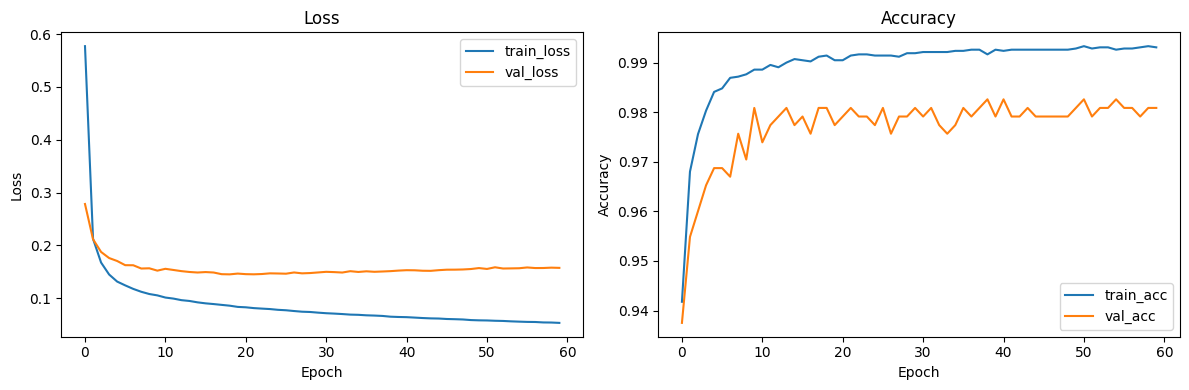

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc_history, label='train_acc')
plt.plot(val_acc_history, label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.show()


 Test evaluation


In [32]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=range(n_classes))
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f"Test Accuracy: {acc:.4f}")
for i in range(n_classes):
    print(f"Class {i}: Precision={prec[i]:.4f}  Recall={rec[i]:.4f}  F1={f1[i]:.4f}")
print(f"\nMacro avg - Precision: {p_macro:.4f}, Recall: {r_macro:.4f}, F1: {f1_macro:.4f}")


Test Accuracy: 0.9875
Class 0: Precision=0.9916  Recall=0.9833  F1=0.9874
Class 1: Precision=0.9835  Recall=0.9876  F1=0.9855
Class 2: Precision=0.9958  Recall=0.9958  F1=0.9958
Class 3: Precision=0.9833  Recall=0.9874  F1=0.9854
Class 4: Precision=0.9834  Recall=0.9834  F1=0.9834

Macro avg - Precision: 0.9875, Recall: 0.9875, F1: 0.9875


Confusion matrix

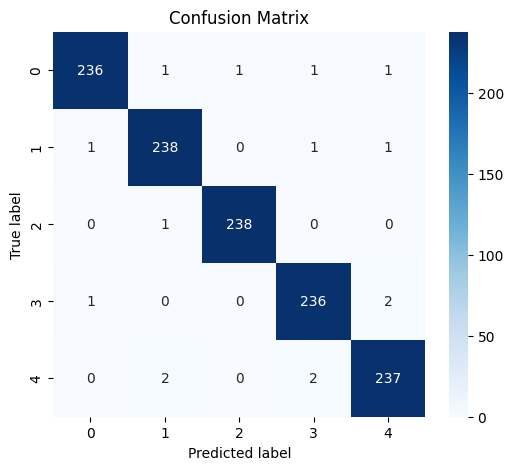

In [33]:
cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.title('Confusion Matrix')
plt.show()